In [104]:
import sys
import os

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [4]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

In [5]:
#def econvergence(E: list[float]):
 #   return np.abs((E[:-1] - E[-1])/E[-1])

def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc
        

## Genero Estructura

In [6]:
AuFCC = bulk('Au', 'fcc', a=4., cubic=True)

In [7]:
calc = GPAW(mode=PW(300), xc='PBE', txt='AuFCC.txt',kpts=[5,5,5])
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-11.567181560509455

In [8]:
import os

In [9]:
calcsdir='calcs_kpoints'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [10]:
structures = [('fcc', AuFCC, 4.0)]

In [11]:
kpoints = [3, 4, 5,7,9,11,13]
Ekpt = {}

In [12]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt"
        # archivos GPAW y txt a guardar 
        gpawfile =os.path.join(calcsdir, f'{name}_kpts_{kpt}.gpaw')
        logfile = os.path.join(calcsdir, f'{name}_{kpt}.txt')
        # cargo el calculador con la función definida antes
        calc = load_calc(gpawfile, mode=PW(300), txt=logfile, xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(gpawfile)

  0%|          | 0/7 [00:00<?, ?it/s]

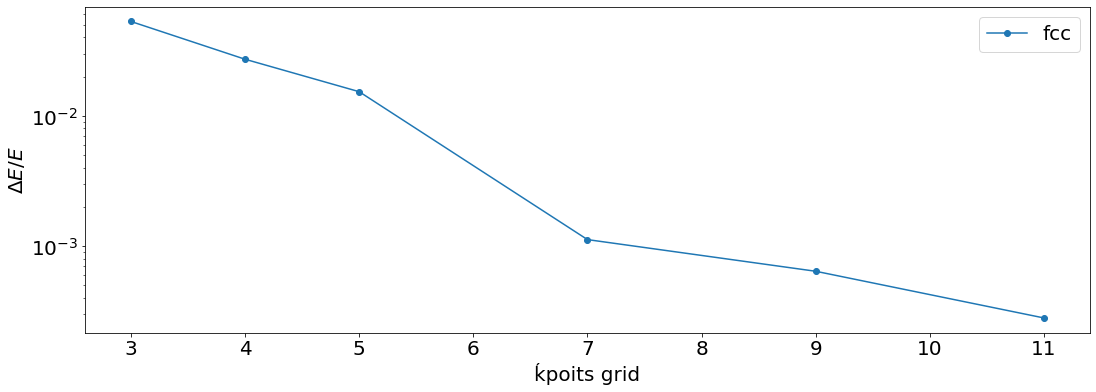

In [13]:
plots = [plt.plot(kpoints[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), '-o', label = struc) for struc, energies in Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('ḱpoits grid')
plt.legend()

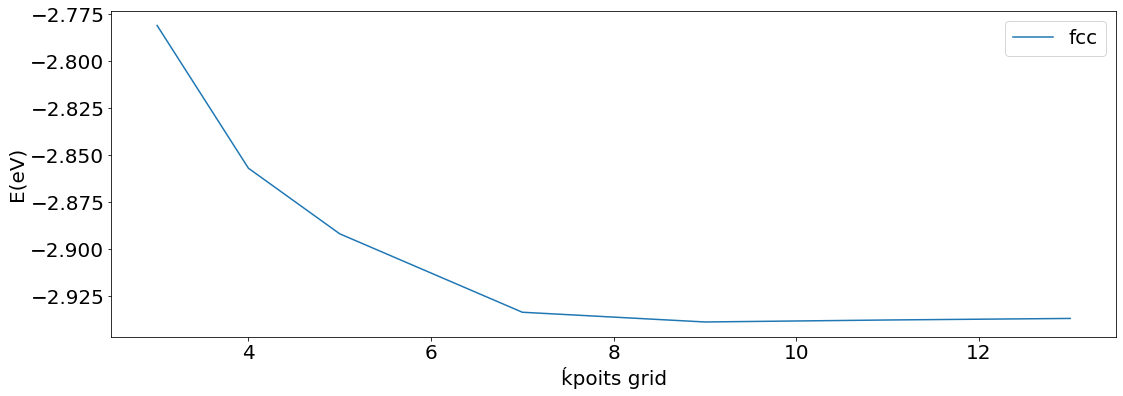

In [14]:
plots = [plt.plot(kpoints, energies, label = struc) for struc, energies in Ekpt.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()

In [15]:
KPT= 10

## Cuttoff Convergence

In [16]:
calcsdir = 'calcs_ecut'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [17]:
ecuts = [200, 250, 300, 400, 500,600]
Ecutoff = {}

In [18]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  4.0)]

In [19]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    progress = tqdm(ecuts)
    for ecut in progress:
        filename = os.path.join(calcsdir, f'{name}_{ecut}.gpaw')
        logfilename = os.path.join(calcsdir, f'{name}_{ecut}.txt')
        # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
        calc = load_calc(filename, mode=PW(ecut), txt=logfilename, xc='PBE', kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(filename)

  0%|          | 0/6 [00:00<?, ?it/s]

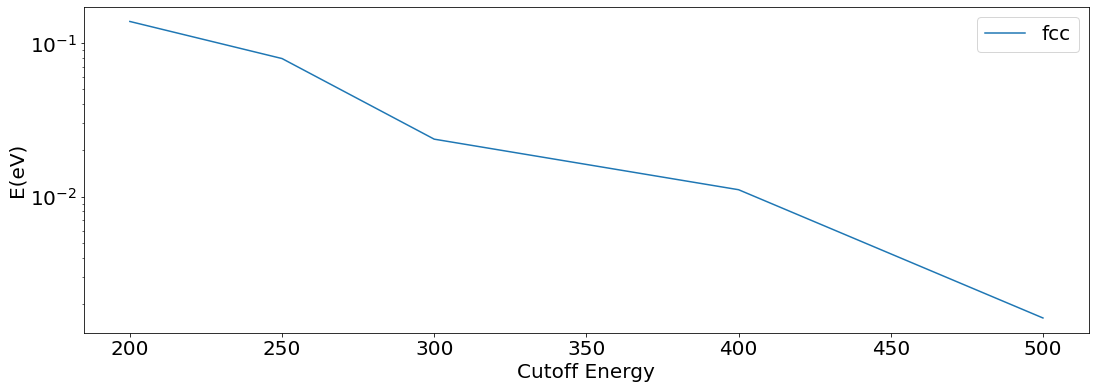

In [20]:
[plt.plot(ecuts[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), label = name) for name, energies in Ecutoff.items()]
plt.yscale('log')
plt.ylabel('E(eV)')
plt.xlabel('Cutoff Energy')
plt.legend()

In [21]:
ECUT = 400

## Lattice Parameter

In [22]:
latparams = {'fcc': np.linspace(3.8,4.5,10)}

In [23]:
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

In [24]:
import ase, gpaw
def doevcurve(name: str, struc: ase.atoms.Atoms, sizes: np.ndarray, gpaw_kwargs:dict):
    """
    name: str con el nombre de la estructura
    struc: atoms object con la estructura a calcular
    sizes: np.ndarray con los parametros de red para esta estructura
    gpaw_kwargs: opciones para gpaw
    """
    E = []
    V = []
    progress = tqdm(sizes)
    for latpar in progress:
        gpawfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.gpaw')
        logfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.txt')
        gpaw_kwargs.update({'txt': logfile})
        calc = load_calc(gpawfile, **gpaw_kwargs)
        struc.set_cell(latpar*np.eye(3), scale_atoms=True) # ojo, esto vale solo para cubicas !
        struc.set_calculator(calc)
        V.append(struc.get_volume())
        E.append(struc.get_potential_energy())
        struc.calc.write(gpawfile)
    return {'V': V, 'E': E}

In [25]:
GPAW_KWARGS = dict(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT])

In [26]:
latparcalcs = 'calcs_latpar'

if not os.path.exists(latparcalcs):
    os.makedirs(latparcalcs)

In [27]:
evcurves={}

In [28]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  4.0)]

In [29]:
for case in structures:
    name, struc, guess = case
    print(guess)
    latparams = np.linspace(guess*0.95, guess*1.05, 10)
    evcurves[name] = doevcurve(name,struc, latparams, GPAW_KWARGS)

4.0


  0%|          | 0/10 [00:00<?, ?it/s]

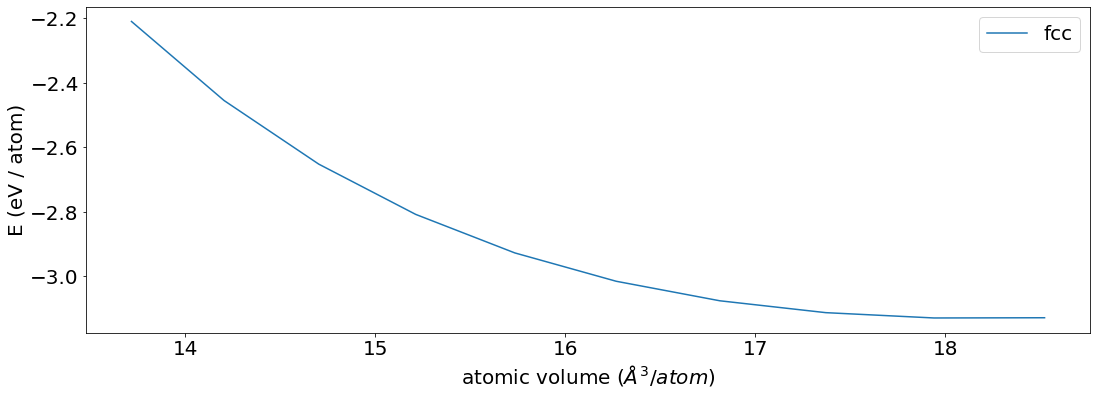

In [30]:
for (name, evcurve), case in zip(evcurves.items(), structures):
    structure = case[1]
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

## Ecuacion de estado

In [31]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [32]:
eos.fit()

(72.76311152153961, -12.5265201753902, 0.8825198612824942)

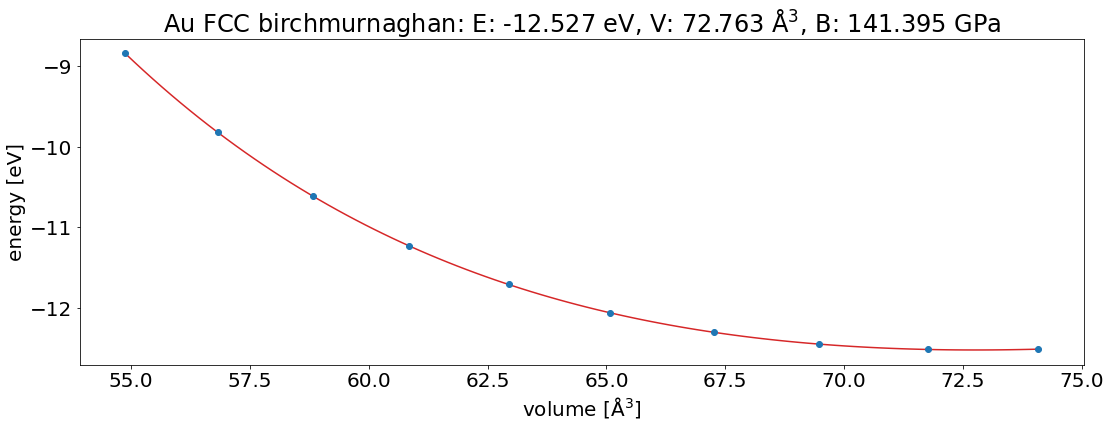

In [33]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Au FCC ' + title)

In [34]:
eqa = eos.v0**(1/3)

In [35]:
eqa

4.174813579284903

Muy parecido a los resultados publicados en este trabajo de NOMAD: https://nomad-lab.eu/prod/v1/gui/search/entries/entry/id/YDXZgPooRb-31Niq48ODPA/SoO62gAV0cVK9WRCD5M-8Xh_T4OV

## Generación de superficie n capas

In [36]:
from ase.build import surface, fcc100, fcc110, fcc111, make_supercell

In [37]:
AuMonoLayer = fcc100('Au',[1,1,1], a=eqa, vacuum=10)

In [38]:
AuBiLayer = fcc100('Au',[1,1,2], a=eqa, vacuum=10)

In [39]:
AuTriLayer = fcc100('Au',[1,1,3], a=eqa, vacuum=10)

In [40]:
AuTetraLayer = fcc100('Au',[1,1,4], a=eqa, vacuum=10)

In [41]:
AuPentaLayer = fcc100('Au',[1,1,5], a=eqa, vacuum=10)

con lo cual construimos una n-capa de oro fcc con índices de miller 100. para poder visualizar esta bicapa con mas repeticiones, podemos repetir mas veces la supercelda que acabamos de crear,

In [42]:
AuMonoLayer_2x2 = make_supercell(AuMonoLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuMonoLayer_3x3 = make_supercell(AuMonoLayer, [[3,0,0],[0,3,0],[0,0,1]])

## MonoCAPA

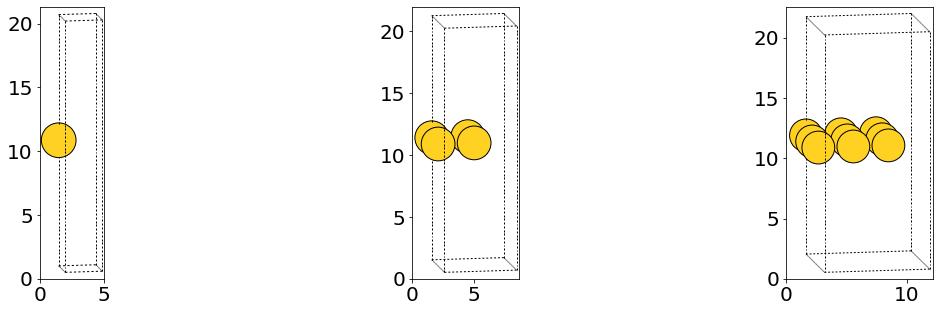

In [43]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuMonoLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuMonoLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuMonoLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])

# BiCapa

In [44]:
AuBiLayer_2x2 = make_supercell(AuBiLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuBiLayer_3x3 = make_supercell(AuBiLayer, [[3,0,0],[0,3,0],[0,0,1]])

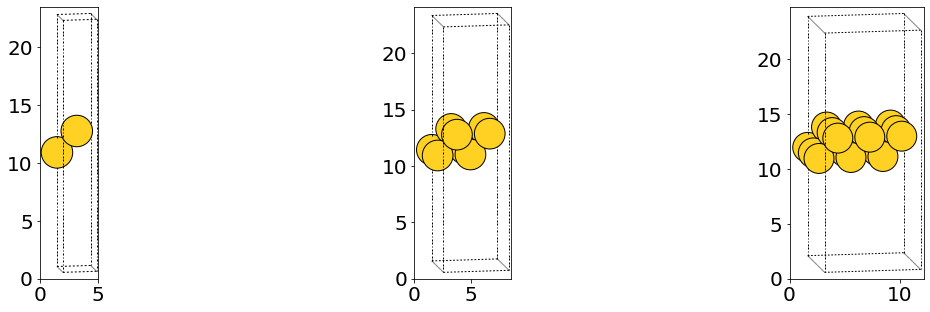

In [45]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuBiLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuBiLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuBiLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])

# TriCapa

In [48]:
AuTriLayer_2x2 = make_supercell(AuTriLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuTriLayer_3x3 = make_supercell(AuTriLayer, [[3,0,0],[0,3,0],[0,0,1]])

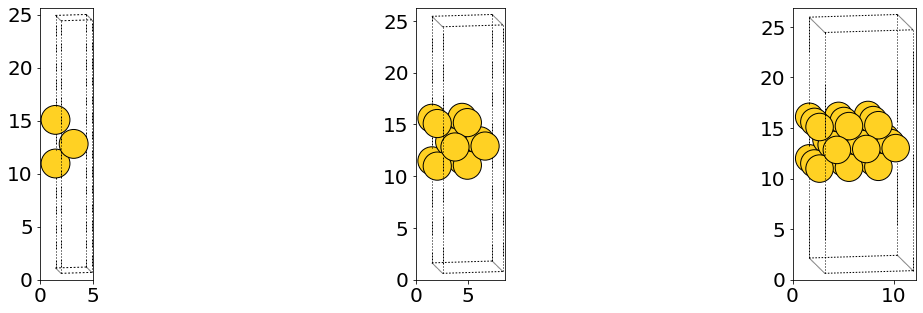

In [49]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuTriLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuTriLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuTriLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])

# TetraCapa

In [50]:
AuTetraLayer_2x2 = make_supercell(AuTetraLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuTetraLayer_3x3 = make_supercell(AuTetraLayer, [[3,0,0],[0,3,0],[0,0,1]])

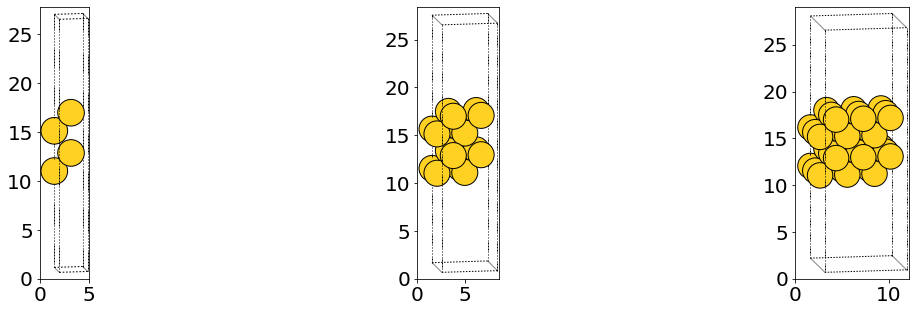

In [51]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuTetraLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuTetraLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuTetraLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])

## Calculos de superficies

In [52]:
layers_dir = 'layers_calcs'

In [53]:
if not os.path.exists(layers_dir):
    os.makedirs(layers_dir)

In [54]:
en_pot100= []

Monocapa de Au / 1° [100]

In [55]:
n = 1
monolayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
monolayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
calc = load_calc(monolayerfile, **GPAW_KWARGS)

AuMonoLayer.set_calculator(calc)
en_pot100.append(AuMonoLayer.get_potential_energy())

In [56]:
AuMonoLayer.calc.write(monolayerfile)

Bicapa de Au / 1° [100]; 2° [110]

In [57]:
n = 2
bilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
bilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuBilayer.txt', xc='PBE', kpts=[KPT/2, KPT/2, 1])
calcBiL = load_calc(bilayerfile, **GPAW_KWARGS)

AuBiLayer.set_calculator(calcBiL)
en_pot100.append(AuBiLayer.get_potential_energy())

In [58]:
AuBiLayer.calc.write(bilayerfile)

Tricapa de Au / 1° [100]; 2° [110]

In [59]:
n = 3
trilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
trilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTrilayer.txt', xc='PBE', kpts=[KPT/3, KPT/3, 1])
calcTriL = load_calc(trilayerfile, **GPAW_KWARGS)

AuTriLayer.set_calculator(calcTriL)
en_pot100.append(AuTriLayer.get_potential_energy())

In [60]:
AuTriLayer.calc.write(trilayerfile)

Tetracapa de Au / 1° [100]; 2° [110]

In [61]:
n = 4
tetralayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
tetralayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTetralayer.txt', xc='PBE', kpts=[KPT/4, KPT/4, 1])
calcTetraL = load_calc(tetralayerfile, **GPAW_KWARGS)

AuTetraLayer.set_calculator(calcTetraL)
en_pot100.append(AuTetraLayer.get_potential_energy())

In [62]:
AuTetraLayer.calc.write(tetralayerfile)

Pentacapa de Au / 1° [100]

In [63]:
n = 5
pentalayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
pentalayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuPentalayer.txt', xc='PBE', kpts=[KPT/5, KPT/5, 1])
calcPentaL = load_calc(pentalayerfile, **GPAW_KWARGS)

AuPentaLayer.set_calculator(calcPentaL)
en_pot100.append(AuPentaLayer.get_potential_energy())

In [64]:
AuPentaLayer.calc.write(pentalayerfile)

# Densidad de estados (DOS)

Bulk

In [65]:
AuFCC = bulk('Au', 'fcc', a=eqa)

In [66]:
bulk_dos_file = os.path.join(layers_dir, f'bulk_{n}_dos.gpaw')
bulk_dos_log = os.path.join(layers_dir, f'bulk_{n}_dos.txt')

In [67]:
GPAW_KWARGS_BULK=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,15], txt=bulk_dos_log)

In [68]:
calc = load_calc(bulk_dos_file, **GPAW_KWARGS_BULK)
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-3.1297045151325977

1 Capa

In [69]:
monolayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
monolayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [70]:
GPAW_KWARGS_monolayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=monolayer_dos_log)

In [71]:
calcML = load_calc(monolayer_dos_file, **GPAW_KWARGS_monolayer)
AuMonoLayer.set_calculator(calcML)
AuMonoLayer.get_potential_energy()

-2.24065492568199

2 Capas

In [72]:
bilayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
bilayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [73]:
GPAW_KWARGS_bilayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/2,15/2,1], txt=bilayer_dos_log)

In [74]:
calcBiL = load_calc(bilayer_dos_file, **GPAW_KWARGS_bilayer)
AuBiLayer.set_calculator(calcBiL)
AuBiLayer.get_potential_energy()

-5.231598077524124

3 Capas

In [75]:
trilayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
trilayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [76]:
GPAW_KWARGS_trilayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/3,15/3,1], txt=trilayer_dos_log)

In [77]:
calcTriL = load_calc(trilayer_dos_file, **GPAW_KWARGS_trilayer)
AuTriLayer.set_calculator(calcTriL)
AuTriLayer.get_potential_energy()

-8.395289935595375

4 Capas

In [78]:
tetralayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
tetralayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [79]:
GPAW_KWARGS_tetralayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/4,15/4,1], txt=tetralayer_dos_log)

In [80]:
calcTetraL = load_calc(tetralayer_dos_file, **GPAW_KWARGS_tetralayer)
AuTetraLayer.set_calculator(calcTetraL)
AuTetraLayer.get_potential_energy()

-11.798664166086342

5 Capas

In [81]:
pentalayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
pentalayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [82]:
GPAW_KWARGS_pentalayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/5,15/5,1], txt=pentalayer_dos_log)

In [83]:
calcPentaL = load_calc(pentalayer_dos_file, **GPAW_KWARGS_pentalayer)
AuPentaLayer.set_calculator(calcPentaL)
AuPentaLayer.get_potential_energy()

-15.291690139234952

Calculo las energias y el DOS de las capas con los indices [100]

In [93]:
e,dos = AuFCC.calc.get_dos(npts=500)
e2_100, dos_ml_100 = AuMonoLayer.calc.get_dos(npts=500)
e3_100, dos_bl_100 = AuBiLayer.calc.get_dos(npts=500)
e4_100, dos_tril_100 = AuTriLayer.calc.get_dos(npts=500)
e5_100, dos_tetral_100 = AuTetraLayer.calc.get_dos(npts=500)
e6_100, dos_pental_100 = AuPentaLayer.calc.get_dos(npts=500)
ef = AuFCC.calc.get_fermi_level()
efml_100 = AuMonoLayer.calc.get_fermi_level()
efbl_100 = AuBiLayer.calc.get_fermi_level()
eftril_100 = AuTriLayer.calc.get_fermi_level()
eftetral_100 = AuTetraLayer.calc.get_fermi_level()
efpental_100 = AuPentaLayer.calc.get_fermi_level()

Gráfico para las capas con indices [100]

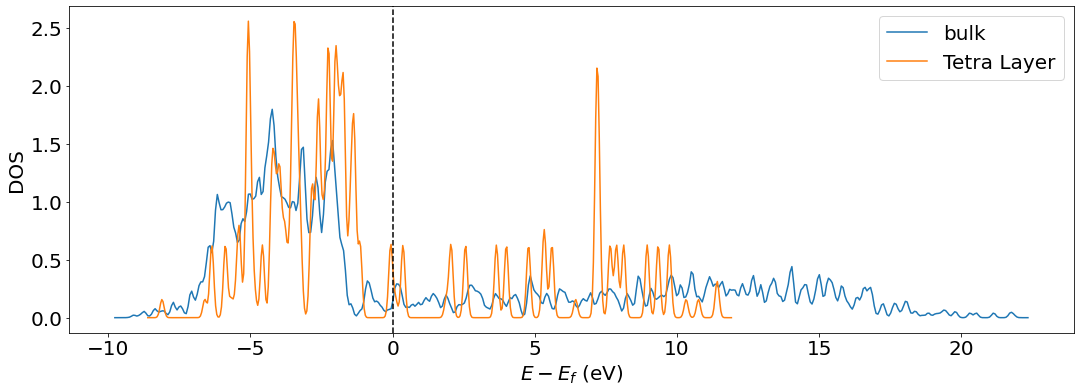

In [109]:
plt.plot(e-ef,dos, label='bulk')
#plt.plot(e2_100-efml_100,dos_ml_100, label='Mono Layer')
#plt.plot(e3_100-efbl_100,(dos_bl_100)/2, label='Bi Layer')
#plt.plot(e4_100-eftril_100,(dos_tril_100)/3, label='Tri Layer')
plt.plot(e5_100-eftetral_100,(dos_tetral_100)/4, label='Tetra Layer')
#plt.plot(e6_100-efpental_100,(dos_pental_100)/5, label='Penta Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.legend()
#normalizado por la cantidad de atomos en las capas.
plt.savefig("DOS - Tetra Capa Vs. Bulk .jpg", )

# Convergencia con el vacio

In [89]:
vacio = np.linspace(1,16,10)

KeyboardInterrupt: ignored

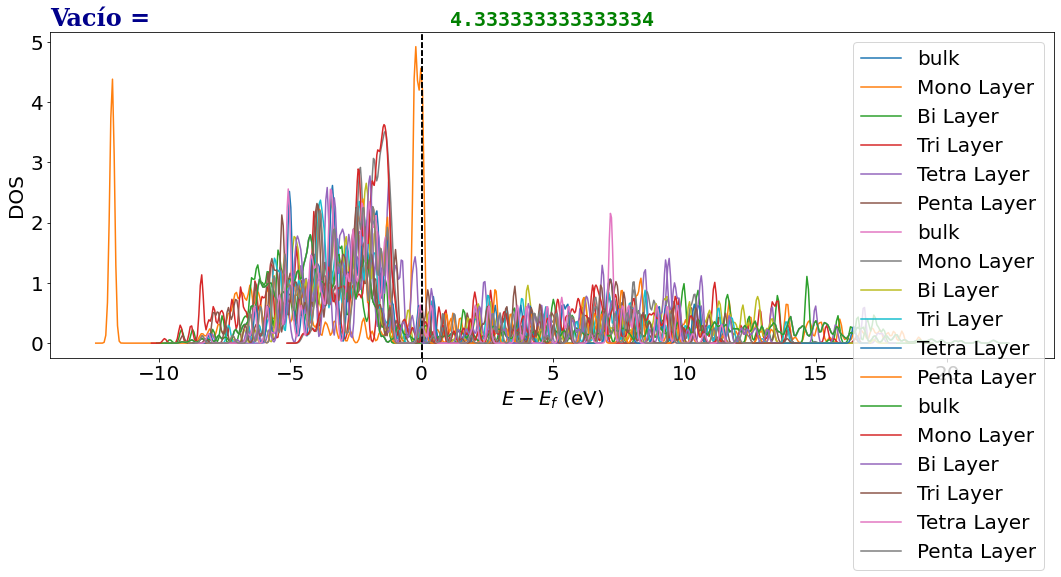

In [106]:
for i in vacio:
  AuMonoLayer = fcc100('Au',[1,1,1], a=eqa, vacuum=i)
  AuBiLayer = fcc100('Au',[1,1,2], a=eqa, vacuum=i)
  AuTriLayer = fcc100('Au',[1,1,3], a=eqa, vacuum=i)
  AuTetraLayer = fcc100('Au',[1,1,4], a=eqa, vacuum=i)
  AuPentaLayer = fcc100('Au',[1,1,5], a=eqa, vacuum=i)
  layers_dir = 'layers_calcs'
  if not os.path.exists(layers_dir):
    os.makedirs(layers_dir)
  en_pot100= []
  n = 1
  monolayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  monolayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
  calc = load_calc(monolayerfile, **GPAW_KWARGS)

  AuMonoLayer.set_calculator(calc)
  en_pot100.append(AuMonoLayer.get_potential_energy())
  AuMonoLayer.calc.write(monolayerfile)

  n = 2
  bilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  bilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuBilayer.txt', xc='PBE', kpts=[KPT/2, KPT/2, 1])
  calcBiL = load_calc(bilayerfile, **GPAW_KWARGS)

  AuBiLayer.set_calculator(calcBiL)
  en_pot100.append(AuBiLayer.get_potential_energy())

  AuBiLayer.calc.write(bilayerfile)

  n = 3
  trilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  trilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTrilayer.txt', xc='PBE', kpts=[KPT/3, KPT/3, 1])
  calcTriL = load_calc(trilayerfile, **GPAW_KWARGS)

  AuTriLayer.set_calculator(calcTriL)
  en_pot100.append(AuTriLayer.get_potential_energy())
  AuTriLayer.calc.write(trilayerfile)

  n = 4
  tetralayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  tetralayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTetralayer.txt', xc='PBE', kpts=[KPT/4, KPT/4, 1])
  calcTetraL = load_calc(tetralayerfile, **GPAW_KWARGS)

  AuTetraLayer.set_calculator(calcTetraL)
  en_pot100.append(AuTetraLayer.get_potential_energy())
  AuTetraLayer.calc.write(tetralayerfile)

  n = 5
  pentalayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  pentalayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuPentalayer.txt', xc='PBE', kpts=[KPT/5, KPT/5, 1])
  calcPentaL = load_calc(pentalayerfile, **GPAW_KWARGS)

  AuPentaLayer.set_calculator(calcPentaL)
  en_pot100.append(AuPentaLayer.get_potential_energy())
  AuPentaLayer.calc.write(pentalayerfile)

  #-------------------------------------------------------------
  #DOS
  AuFCC = bulk('Au', 'fcc', a=eqa)
  bulk_dos_file = os.path.join(layers_dir, f'bulk_{n}_dos.gpaw')
  bulk_dos_log = os.path.join(layers_dir, f'bulk_{n}_dos.txt')
  GPAW_KWARGS_BULK=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,15], txt=bulk_dos_log)
  calc = load_calc(bulk_dos_file, **GPAW_KWARGS_BULK)
  AuFCC.set_calculator(calc)
  AuFCC.get_potential_energy()
#1 Capa
  monolayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
  monolayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')
  GPAW_KWARGS_monolayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=monolayer_dos_log)
  calcML = load_calc(monolayer_dos_file, **GPAW_KWARGS_monolayer)
  AuMonoLayer.set_calculator(calcML)
  AuMonoLayer.get_potential_energy()
#2 Capas
  bilayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
  bilayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')
  GPAW_KWARGS_bilayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/2,15/2,1], txt=bilayer_dos_log)
  calcBiL = load_calc(bilayer_dos_file, **GPAW_KWARGS_bilayer)
  AuBiLayer.set_calculator(calcBiL)
  AuBiLayer.get_potential_energy()
  #3Capas
  trilayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
  trilayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')
  GPAW_KWARGS_trilayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/3,15/3,1], txt=trilayer_dos_log)
  calcTriL = load_calc(trilayer_dos_file, **GPAW_KWARGS_trilayer)
  AuTriLayer.set_calculator(calcTriL)
  AuTriLayer.get_potential_energy()
  #4 Capas
  tetralayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
  tetralayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')
  GPAW_KWARGS_tetralayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/4,15/4,1], txt=tetralayer_dos_log)
  calcTetraL = load_calc(tetralayer_dos_file, **GPAW_KWARGS_tetralayer)
  AuTetraLayer.set_calculator(calcTetraL)
  AuTetraLayer.get_potential_energy()
  #5 Capas
  pentalayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
  pentalayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')
  GPAW_KWARGS_pentalayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15/5,15/5,1], txt=pentalayer_dos_log)
  calcPentaL = load_calc(pentalayer_dos_file, **GPAW_KWARGS_pentalayer)
  AuPentaLayer.set_calculator(calcPentaL)
  AuPentaLayer.get_potential_energy()

  #GRAFICO
  e,dos = AuFCC.calc.get_dos(npts=500)
  e2_100, dos_ml_100 = AuMonoLayer.calc.get_dos(npts=500)
  e3_100, dos_bl_100 = AuBiLayer.calc.get_dos(npts=500)
  e4_100, dos_tril_100 = AuTriLayer.calc.get_dos(npts=500)
  e5_100, dos_tetral_100 = AuTetraLayer.calc.get_dos(npts=500)
  e6_100, dos_pental_100 = AuPentaLayer.calc.get_dos(npts=500)
  ef = AuFCC.calc.get_fermi_level()
  efml_100 = AuMonoLayer.calc.get_fermi_level()
  efbl_100 = AuBiLayer.calc.get_fermi_level()
  eftril_100 = AuTriLayer.calc.get_fermi_level()
  eftetral_100 = AuTetraLayer.calc.get_fermi_level()
  efpental_100 = AuPentaLayer.calc.get_fermi_level()
  fig, ax = plt.subplots()
  plt.plot(e-ef,dos, label='bulk',ax=ax[0])
  plt.plot(e2_100-efml_100,dos_ml_100, label='Mono Layer',ax=ax[1])
  plt.plot(e3_100-efbl_100,(dos_bl_100)/2, label='Bi Layer'ax=ax[2])
  plt.plot(e4_100-eftril_100,(dos_tril_100)/3, label='Tri Layer'ax=ax[3])
  plt.plot(e5_100-eftetral_100,(dos_tetral_100)/4, label='Tetra Layer'ax=ax[4])
  plt.plot(e6_100-efpental_100,(dos_pental_100)/5, label='Penta Layer',ax=ax[5])
  plt.axvline(color='k', linestyle='--')
  plt.xlabel('$E - E_f$ (eV)')
  plt.ylabel('DOS')
  plt.title("Vacío =", 
            fontdict={'family': 'serif', 
                      'color' : 'darkblue',
                      'weight': 'bold',
                      'size': 24},
            loc='left')
  plt.title(i, 
            fontdict={'family': 'monospace', 
                      'color' : 'green',
                      'weight': 'bold',
                      'size': 20},
            loc='center') 
  plt.legend()
  plt.savefig("DOS - .jpg")
  
#normalizado por la cantidad de atomos en las capas.